# Portfolio Optimization using Reverse Quantum Annealing

## Introduction

This chapter presents the utilization of Reverse Quantum Annealing for resolving portfolio optimization issues through the utilization of OpenJij. Reverse Quantum Annealing is an approach that amalgamates classical optimization methodologies with quantum annealing. The chapter is structured in the following manner: We will elaborate on the methods of resolving portfolio optimization problems through classical algorithms, standard quantum annealing, and reverse quantum annealing. Subsequently, we contrast the outcomes obtained from these techniques. Throughout the chapter, we will describe the implementation of quantum annealing via OpenJij and accentuate any potential limitations or caveats of the numerical experiments.

*Note: Note: Execution of this content requires OpenJij version 0.4.9 or higher. If necessary, please execute the following command to update OpenJij prior to proceeding with this notebook.*

```bash
pip install -U openjij
```

## Portfolio Optimization

  In the realm of asset management, investors strive to achieve substantial returns while minimizing risk as much as feasible. 
  Consequently, a prevalent approach is to construct a diversified investment portfolio by integrating assets with moderate returns but minimal (or no) risk and assets with substantial expected returns but also substantial risk.  

  In this scenario, an optimal portfolio must be chosen in order to achieve the maximal profit for a given level of risk or to minimize the risk while obtaining the same profit.
  One of the most widely utilized methodologies currently is the Modern Portfolio Theory proposed by Markowitz.
  This method takes into account the interdependencies among the stocks comprising the portfolio and aims to minimize their covariance [1].

  $$
  \min \sum_{i=1}^{N}\sum_{j=1}^{N}w_{i}w_{j}\sigma_{ij}; \quad \sum_{i=1}^{N}W_{i}=1; \quad \sum_{i=1}^{N}W_{i}\mu_{i}=R
  $$

  $W_i, \sigma_{ij}, \mu_i$, and $R$ denote the weight of each stock in the portfolio, the covariance among the stocks, the expected return of each stock, and the total return of the portfolio, respectively.

  Here, the Sharpe ratio is a widely-utilized metric for assessing the performance of a portfolio.

  ### Sharpe Ratio

  The Sharpe ratio, proposed by William Sharpe in 1966 [3], is a metric for evaluating the efficiency of an investment, applied to both individual stocks and portfolios. It is defined as follows

  $$
  S = \frac{\bar{r}-r_0}{\sigma}
  $$

  Here, $\bar{r}$ represents the average rate of return over a specified time period, typically calculated using the mean of monthly or annual returns. 
  $r_0$ is the rate of return in the risk-free context, usually represented by the interest rate of a stable government bond. 
  $\sigma$ denotes volatility, which is the degree of fluctuation in asset values.   

  The calculation of the Sharpe ratio varies depending on the situation, and the methodologies for determining return and volatility may include using simple returns calculated from asset price $P$ as $r=P(t+1)/P(t) - 1$, or log returns calculated as $r=log[P(t+1)/P(t)]$. 
  Also volatility can be determined from price changes or from the rate of return. 
  For a more comprehensive examination of these methodologies, please refer to literature and resources about financial engineering and market analysis.

  ### Portfolio Evaluation and Optimization

  As per the definition of the Sharpe ratio, a high value connotes high returns or low risk (volatility). 
  Among portfolios constructed from a given set of stocks, the combination that attains the highest Sharpe ratio can be considered as the combination that yields the highest returns per a unit of risk. 
  Thus, the problem of portfolio optimization can be rephrased as the problem of maximizing the Sharpe ratio under a given constraint.  

  In practice, this optimization process involves identifying stocks and determining the proportion of investment allocated to each stock. 
  In other words, it is a combinatorial optimization problem that involves determining the selection of stocks and the weight assigned to each stock. 
  For simplicity, this tutorial will adopt a strategy in which each stock is assigned an equal weight, as per the referenced paper [2]. 
  We select $N$ stocks out of a total of $M$ stocks and find the combination that maximizes the Sharpe ratio. 
  Then, the problem can be formulated into the QUBO form as follows.

  $$
  \mathcal{O}(\boldsymbol{q})=\sum_{i=1}^{N}a_{i}q_{i}+\sum_{i=1}^{N}\sum_{j=i+1}^{N}b_{ij}q_{i}q_{j}
  $$

  Here, $q_{i}$ is a binary variable that denotes the selection of each stock, where a value of $1$ indicates inclusion in the portfolio and a value of $0$ indicates non-inclusion. 
  $a_i$ is the score of attractiveness, derived from the performance of the individual stock, and $b_{ij}$ represents the fines or bonuses as determined by the pairwise correlation between stocks.  

  The specific values of $A_i$ and $B_{ij}$ are established in accordance with the Table 1 below.

  <img src="../../../assets/reverse_annealing_RQA_QUBO.png">

  The $a_i$ groups in this table are criteria established by the portfolio's creators, with stocks ordered by their attractiveness.
  The table displays the groups formed when they are ranked and divided equally. 
  The attractiveness criterion can also incorporate factors such as a high rate of return, but for this tutorial, we simply use the order of individual stocks based on the Sharpe ratio. 
  $B_{ij}$ is determined by the value of the component $\rho_{ij}$ of the correlation matrix obtained from the time series of log returns.  

  By performing quantum annealing using this QUBO, we should be able to obtain the optimal portfolio. 
  If multiple stocks are selected, a constraint on the number of stocks can be added. 
  However, as described in the referenced paper [2], when constraints are added to the QUBO using this method, the large interaction (penalty) introduced can also affect the annealing performance and the final results obtained. 
  In a real-world scenario, the number of stocks in the optimal portfolio is unknown, thus, this tutorial performs the same optimization without any restriction on the number of stocks.

## Portfolio Optimization with Reverse Quantum Annealing

The problem of portfolio optimization in the real world is to select a subset of stocks from a market with a vast array of options. 
Additionally, due to the huge number of possible stock combinations, it is likely that there exist numerous local minima, which correspond portfolios with Sharpe ratios that are quite close to the maximum. 
Conventional algorithms, when trapped in the trough of such an energy landscape, need a significant amount of time and resources to escape. 
To circumvent the above issue and solve portfolio optimization problems more efficiently, computational methods such as quantum annealing, which can handle a large number of correlations and are less prone to getting trapped in local minima, are more effective.  

However, as demonstrated in the reference paper [2], when only simple forward annealing is used, the time required to reach the optimal solution increases dramatically as the number of issues increases. 
This is because the difference in energy between the optimal solution and local minima with a Sharpe ratio close to the optimal solution is small. 
Due to a high potential barrier between these levels with almost no energy change, transition from local minima to optimal require a longer time.
Furthermore, in actual quantum annealing machines, the system may be excited by thermal noise or other factors during standard annealing, resulting in a deviation from the intended time evolution and a final solution that is not truly optimal obtained.

### Reverse Quantum Annealing

One of the proposed methods for addressing the challenges associated with using quantum annealing in portfolio optimization is reverse quantum annealing. 
As the name implies, this approach involves conducting quantum annealing in a manner that incorporates a step in the opposite direction of conventional forward annealing. 
The time-dependent Hamiltonian of standard forward annealing is represented as

$$
\mathcal{H}_{\mathrm{QA}}(t)=A[t]\sum_{i=1}^N\sigma_{i}^{\mathrm{x}}+B[t]\mathcal{H}_{\chi-\mathrm{Ising}}
$$

where $A[t]$ is the magnitude of the transverse magnetic field applied to the system during annealing, and $B[t]$ represents the amplitude of the problem Hamiltonian $\mathcal{H}_{\chi-\mathrm{Ising}}$, respectively. 
As depicted in the following figure a), in the case of forward annealing, $A[t]$ is gradually decreased as the annealing progresses, and concurrently, $B[t]$ is made dominant.
At the completion of annealing, $A[t] = 0$.

<img src="../../../assets/reverse_annealing_QAandRQA.png">

In contrast, reverse annealing starts from $A[t]=0, B[t]=1$, as depicted in Figure b).
In this method, $B[t]$ is initially decreased, in contrast to the standard annealing.
This is referred to as the reverse phase.
In this phase, the system's energy is inversely increased, making it easier to tunnel the potential barrier between A and B, as illustrated in c).
After $A[t]$ and $B[t]$ reach a specific value, the system is kept in the same state and allowed to wait for a while. 
This is referred to as the pause phase.
During this phase, a high energy state is maintained, increasing the likelihood of thermal hopping. 
The potential barrier on the right side of B is also easily overcome.
This suggests that the possibility of escaping from the initial local minimum and reaching a near-optimal solution is increased. 
Finally, the optimal solution is attained by conducting standard annealing in the forward phase, which once again makes $A[t]$ smaller and $B[t]$ larger.
In this protocol, the performance of the final solution may also be impacted by the value at which $A[t], B[t]$ is stopped in the reverse phase, the duration of each phase, etc.

### Portfolio Optimization Procedure with Reverse Quantum Annealing

From the previous discussion, reverse annealing requires a reverse phase initial state.
While it can be used randomly generated initial states, it is predicted that the efficacy of the optimal solution search will be enhanced when a specific local minumu state is implemented.
The reference paper [2] employs the output generated by a conventional algorithm.
This tutorial will follow the method outlined in the reference paper [2], which entails the following steps. 

* Generation of data for stocks to be optimizaed
* Implementation of a classical algorithm and examination of its results
* Search for an optimal solution through standard forward annealing
* Search for an optimal solution through reverse quantum annealing
* Exploration of parameters for reverse quantum annealing

## Generation of stock data and implementation of classical algorithms

### Generation of stock data to be optimized

We generate a chart of stocks by Brownian motion using the given initial values according to the method in reference paper [2].

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

#Magic numbers to generate assets
rho = 0.1 # input uniform correlation
mu = 0.075 # expected value
sigma = 0.15 # volatility/standard error
r0 = 0.015 # no risk return

The motion of the chart at each time, as outlined in Appendix A of reference paper [2], is derived from the motion at the preceding time, as follows:

$$
S(t_{n+1})=S(t_n)\exp(\mu-\frac{1}{2}\sigma^2)\Delta t + \sigma Z_n\sqrt{\Delta t}
$$

where $Z_n$ is the multivariate normal distribution following the uniform correlation matrix ρ, constructed via the Cholesky decomposition.  

We shall now implement and run this equation, and plot the chart to observe its appearance. 
By beginning with the same initial value and examining the 12-month trend, we can discern the overall behavior to spread out.
Additionally, we can observe certain stocks note any significant increases or decreases.

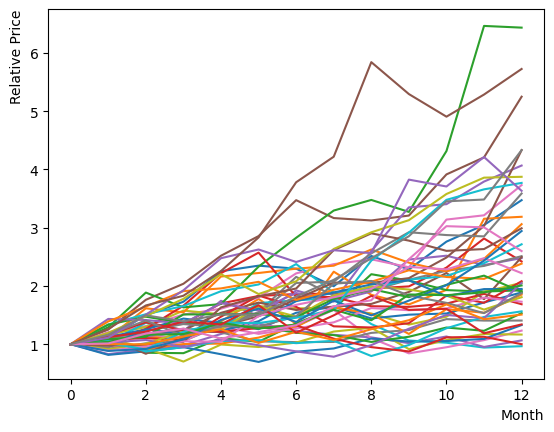

In [2]:
# generate correlated normal probability variables, Zn
def createZvariables(N, rho):
  rho_mat = np.full((N,N), rho)
  rho_mat[range(N), range(N)] = 1.0
  rho_chole = np.linalg.cholesky(rho_mat)
  zNs_temp = np.random.normal(0, 1, (10000, N))
  zNs = zNs_temp @ rho_chole
  return zNs

# generate Brownian motion of the chart
def GetNextSt(St, mu, sigma, zN):
  Deltat = 1
  scale = np.exp((mu-0.5*sigma*sigma)*Deltat + sigma*zN*np.sqrt(Deltat))
  NextSt = St * scale
  return NextSt

Nassets = 48 # the number of stocks
chart = list()
ZList = list()
Zvariables = createZvariables(Nassets, rho)
Zlabels = random.sample([x for x in range(10000)], 12) #Z variable shuffle

for label in Zlabels:
  ZList.append(Zvariables[label])

for iasset in range(Nassets):
  chart_asset = [1.0] # initial value: 1.0 at relative price

  # simulate 12 steps (12 months)
  for month in range(12):
    chart_asset.append(GetNextSt(chart_asset[month], mu, sigma, ZList[month][iasset]))

  chart.append(chart_asset)
  #print(chart_asset) # display specific values for each stocks
  plt.plot(list(range(13)), chart_asset)

plt.xlabel("Month", loc="right")
plt.ylabel("Relative Price", loc="top")
plt.show()


Next, the Sharpe Ratio is calculated for each stock. 
Utilizing the realized Sharpe Ratio, we evaluate the earlier outcome. 
Following its definition, we determine the average return exceeded the risk-free rate of return, $\overline{r}$ and the standard deviation of the excess return rate $\sigma$. 
As plot of the chart , when the number of stocks is limited, there is a significant bias due to chance and existence of correlation among the stocks in generation condition.
Therefore, we mitigate their impact by generating 100 iterations and assessing the average Shape ratio.
Consequently, we can see that the average Sharpe ratio of the stocks is $0.4$. 
Additionally, when the definition of the Sharpe ratio calculation is changed, the Sharpe ratio will naturally vary, but it will generally remain within the range of $0.40 \pm 0.05$.

In [3]:
# function for generating assets
def CreateAssets(Nassets): 
  chart = list()
  ZList = list()
  Zvariables = createZvariables(Nassets, rho)
  Zlabels = random.sample([x for x in range(10000)], 12)
  for label in Zlabels:
    ZList.append(Zvariables[label])
  for iasset in range(Nassets):
    chart_asset = [1.0]
    for month in range(12):
      chart_asset.append(GetNextSt(chart_asset[month], mu, sigma, ZList[month][iasset]))
    chart.append(chart_asset)
  return chart

# function for computing standard Sharpe ratio
def CalculateSharpeRatio(asset):
    monthly_return = list()
    for month in range(12):
      valueChange = asset[month+1]/asset[month] - 1.0 - r0
      monthly_return.append(valueChange)

    annualized_excess_return = np.mean(monthly_return)
    volatility = np.std(monthly_return, ddof=1)

    return(annualized_excess_return/volatility)

# function for computing Sharpe ratio based on log-return
def CalculateSharpeRatio_log(asset):
  monthly_log_return = list()
  for month in range(12):
    valueChange = np.log(asset[month+1]/asset[month])
    monthly_log_return.append(valueChange)
  mean_log_return = np.mean(monthly_log_return)
  volatility = np.std(monthly_log_return, ddof=1)

  return (mean_log_return-r0)/volatility

# function for computing Sharpe ratio with a slightly different definition
def CalculateSharpeRatio_2(asset):
  monthly_log_return = list()
  monthly_return = list()
  for month in range(11):
    log_valueChange = np.log(asset[month+1]/asset[month])
    monthly_log_return.append(log_valueChange)
    valueChange = asset[month+1]/asset[month] - 1.0
    monthly_return.append(valueChange)
  annualized_excess_return = np.mean(monthly_return) - r0
  volatility = np.std(monthly_log_return, ddof=1)

  return (annualized_excess_return/volatility)

allmean = 0
for ntry in range(100): # multiple execution to eliminate the effect of correlations that are not in the same set
  Chart = CreateAssets(48) # create a specified number of assets
  mean_SR = 0.0
  n = 0.
  for asset in Chart:
    assetSR = CalculateSharpeRatio(asset) # choose the way of computation of Sharpe ratio
    #assetSR = CalculateSharpeRatio_log(asset)
    #assetSR = CalculateSharpeRatio_2(asset)
    mean_SR = ((mean_SR*n)+assetSR) / (n+1) # average of Shape ratio
    n+=1
  print("SubSet "+ str(ntry)+ " average Sharpe Ratio: " + str(mean_SR))
  allmean = ((allmean*ntry)+mean_SR) / (ntry+1)
  print("Average Sharpe Ratio of all generated: "+ str(allmean))

SubSet 0 average Sharpe Ratio: 0.3837906264586552
Average Sharpe Ratio of all generated: 0.3837906264586552
SubSet 1 average Sharpe Ratio: 0.28337786315793195
Average Sharpe Ratio of all generated: 0.3335842448082936
SubSet 2 average Sharpe Ratio: 0.27848598101975913
Average Sharpe Ratio of all generated: 0.31521815687878213
SubSet 3 average Sharpe Ratio: 0.374543783028112
Average Sharpe Ratio of all generated: 0.3300495634161146
SubSet 4 average Sharpe Ratio: 0.5717125711998081
Average Sharpe Ratio of all generated: 0.37838216497285326
SubSet 5 average Sharpe Ratio: 0.283219918751404
Average Sharpe Ratio of all generated: 0.36252179060261175
SubSet 6 average Sharpe Ratio: 0.46652989369562214
Average Sharpe Ratio of all generated: 0.37738009104447034
SubSet 7 average Sharpe Ratio: 0.4514577533529913
Average Sharpe Ratio of all generated: 0.38663979883303545
SubSet 8 average Sharpe Ratio: 0.18780237065172986
Average Sharpe Ratio of all generated: 0.3645467512573348
SubSet 9 average Shar

### Search with Classical Algorithms

The subsequent step is to prepare the QUBO matrix and implement the functions required for the classical algorithm.
Here, the pairwise correlation matrix is computed with logarithmic returns, as following the paper.

In [4]:
import heapq
import pandas as pd
import copy

#Attractiveness Coversion
def SRBucket(SR_list):
    Buckets=sorted(SR_list)
    Buckets.reverse()
    GroupedList = list(np.array_split(Buckets,11))
    for i in range(len(SR_list)):
        if   SR_list[i] in GroupedList[0]: SR_list[i]=15
        elif SR_list[i] in GroupedList[1]: SR_list[i]=12
        elif SR_list[i] in GroupedList[2]: SR_list[i]=9
        elif SR_list[i] in GroupedList[3]: SR_list[i]=6
        elif SR_list[i] in GroupedList[4]: SR_list[i]=3
        elif SR_list[i] in GroupedList[5]: SR_list[i]=0
        elif SR_list[i] in GroupedList[6]: SR_list[i]=-3
        elif SR_list[i] in GroupedList[7]: SR_list[i]=-6
        elif SR_list[i] in GroupedList[8]: SR_list[i]=-9
        elif SR_list[i] in GroupedList[9]: SR_list[i]=-12
        elif SR_list[i] in GroupedList[10]: SR_list[i]=-15

#Penalty/Reward Conversion 
def CorrelationBucket(Corr):
    for i in range(len(Corr)):
        for j in range(len(Corr)):
            if Corr[i][j] >= -1.00 and  Corr[i][j] < -0.25: Corr[i][j] = -5
            elif Corr[i][j] >= -0.25 and  Corr[i][j] < -0.15: Corr[i][j] = -3
            elif Corr[i][j] >= -0.15 and  Corr[i][j] < -0.05: Corr[i][j] = -1
            elif Corr[i][j] >= -0.05 and  Corr[i][j] < 0.05: Corr[i][j] = 0
            elif Corr[i][j] >= 0.05 and  Corr[i][j] < 0.15: Corr[i][j] = 1
            elif Corr[i][j] >= 0.15 and  Corr[i][j] < 0.25: Corr[i][j] = 3
            elif Corr[i][j] >= 0.25 and  Corr[i][j] < 1.00: Corr[i][j] = 5

#Ising component for classical algorithms
def hi(SR_list, Corr, i):
    h = 0.5*SR_list[i] + np.sum(Corr[i])
    return h

def jij(Corr, i, j):
    return 1./4.*Corr[i][j]

#Create Pairwise Correlation Matrix
def CreateCorrMat(Chart):
    assets = list()
    for iasset in range(len(Chart)):
        returns = list()
        for month in range(12):
            log_return = np.log(Chart[iasset][month+1]/Chart[iasset][month])
            returns.append(log_return)
        assets.append(returns)
    Chart_pd = pd.DataFrame(assets).T
    pairwise_corr = Chart_pd.corr(method='pearson')
    return pairwise_corr

#Initial state for Greedy Search and Genetic Algorithm
def GenerateRandomSolution(Nassets):
    Solution = np.random.randint(2, size=Nassets)
    for i in range(Nassets):
        Solution[i] = 2*Solution[i] - 1
    return Solution

# compute Sharpe ratio from obtained portfolio
def EvaluateSolution(Solution,Chart):
    selected_assets = list()
    for i in range(len(Solution)):
        if Solution[i] == 1:
            selected_assets.append(Chart[i])
    portfolioChart = np.mean(selected_assets, axis=0)
    portfolioSR = CalculateSharpeRatio(portfolioChart)
    return portfolioSR

# introduce mutations to make next generation in genetic algorithm
def CreateDescendant(Ancestor, Ndescendants, MaxMutation):
    n = 0
    index_list = range(len(Ancestor))
    Descendants = list()
    while n < Ndescendants:
        Nmutaion = np.random.randint(MaxMutation)
        Place_to_change = np.random.choice(index_list, size=Nmutaion, replace=False)
        Descendant = list()
        for place in Place_to_change:
            Descendant = copy.deepcopy(Ancestor)
            Descendant[place] = Ancestor[place] * -1
            Descendants.append(Descendant)
        n += 1
    return Descendants

In [5]:
# regenerate set of assets
# we use this set of assets from here
Nassets = 48

Chart = CreateAssets(Nassets)
PairwiseCorrMat = CreateCorrMat(Chart)
SR_list = list()

for asset in Chart:
    SR_list.append(CalculateSharpeRatio(asset))

# convert from Bucket
SRBucket(SR_list)
CorrelationBucket(PairwiseCorrMat)

#print(PairwiseCorrMat)　# display pairwise correlation matrix

#### Greedy Method

First, we conduct a greedy search algorithm.
Commencing from a randomly generated initial state, we select stocks that are likely to increase the Sharpe ratio of the portfolio, by examining their impact on overall performance. 
By iterating, we can observe that the algorithm converges from a random initial state to a particular state.  

After execution, we compare the initial state with the state obtained by the greedy method. 
The reference of comparison is the Sharpe Ratio of the portfolio. 
In this tutorial, the calculation is based on the scenario where all stocks have the same weight, thus the average chart of the selected stocks is used to calculate the Sharpe ratio.
We can also observe that if we reset the set of stocks by running the previous code block multiple times, the results of the greedy method may be inferior to the initial state or remain almost unchanged.   

There also appear final states where the final returns are inferior to the initial state, but the Sharpe Ratio is larger. 
Comparing these final states, we can see that the portfolio with a larger Sharpe ratio has a smoother chart and smaller fluctuations (less risky).

Initial random selection:
[ 1  1  1 -1 -1 -1 -1  1  1  1 -1  1  1  1 -1 -1  1  1 -1  1  1 -1 -1  1
  1 -1 -1 -1 -1 -1  1  1 -1  1  1  1 -1  1  1  1 -1 -1  1 -1 -1 -1 -1 -1] 3.018178347830132

Selection After Greedy Search:
[ 1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  1  1  1  1  1  1  1  1
 -1  1 -1 -1 -1 -1  1 -1  1 -1  1 -1 -1  1  1 -1  1  1  1  1 -1  1 -1  1] 4.45844050991915



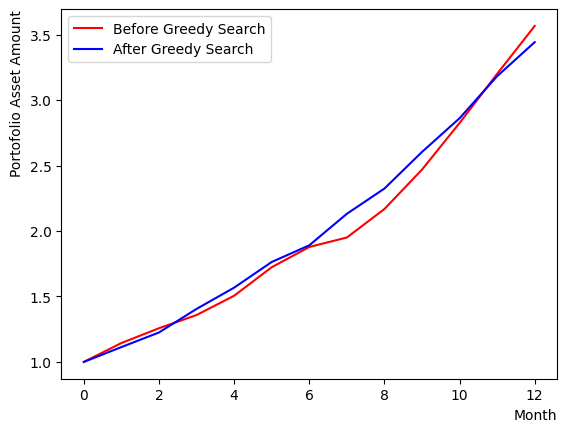

In [6]:
#Greedy Search

# generate initial state
Solution = GenerateRandomSolution(Nassets)
print("Initial random selection:")
print(Solution, EvaluateSolution(Solution, Chart))
print("")

selected_charts = list()
for i in range(Nassets):
    if Solution[i] == 1:
        selected_charts.append(Chart[i])
portfolioChart = np.mean(selected_charts, axis=0)

# initialize energy based on initial state
Energies = list()
for iasset in range(Nassets):
    h = hi(SR_list, PairwiseCorrMat, iasset)
    energyTuple = [-1*abs(h), h , iasset]
    Energies.append(energyTuple)

# execute greedy search
NGreedyLoop = 10
for i in range(NGreedyLoop):
    heapq.heapify(Energies)

    ntry = 0
    #print(Energies) # display energy change
    while(ntry < len(Energies)):
        x, e, i = heapq.heappop(Energies)
        if e > 0:
            Solution[i] = -1.
        else:
            Solution[i] = 1.
        for ie in Energies:
            n = ie[2]
            ie[1] = ie[1] + Solution[i]*(jij(PairwiseCorrMat, i, n) + jij(PairwiseCorrMat, n, i))
            ie[0] = -ie[1]
        ntry+=1


# output of greedy search 
print("Selection After Greedy Search:")
print(Solution, EvaluateSolution(Solution, Chart))
print("")

selected_charts2 = list()
for i in range(Nassets):
    if Solution[i] == 1:
        selected_charts2.append(Chart[i])
portfolioChart2 = np.mean(selected_charts2, axis=0)

plt.plot(list(range(13)), portfolioChart,color="r",label="Before Greedy Search")
plt.plot(list(range(13)), portfolioChart2,color="b",label="After Greedy Search")
plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.legend()
plt.show()

#### Genetic Algorithm

An alternate classical algorithm to the greedy method is the genetic algorithm.
It selects the most optimal solution from a number of randomly generated portfolios and generates the next iteration of portfolios based on that optimal solution.
The subsequent step of portfolios is generated through mutations that introduce random modifications to the previous step portfolios, and through crossover which exchanges genetic traits between portfolios.
Given the relatively small number of stocks in this scenario, we only consider mutations and abstain from genetic crossover.
By comparing the results, it is evident that the performance of the final computed generation surpasses that of the initial one.
As the number of iterations attempted here is limited, performance may not improve or the improvement may be trivial.
However, it is also apparent that, in general, the output is more stable than that of the greedy method.

Note: Increasing the number of genetic pairs, the number of offspring, and the number of mutations may result in an increase in computational complexity, causing the calculation to not be completed. 
Therefore, please adjust the settings according to your execution environment.

Best Gene 1st generation:
[ 1 -1 -1 -1 -1 -1 -1  1 -1  1  1  1 -1 -1  1 -1 -1 -1  1  1  1  1  1 -1
  1  1  1  1 -1  1 -1 -1  1 -1 -1  1 -1  1 -1  1 -1  1  1  1 -1 -1  1  1] 3.1009991529339853

Best Gene last generation:
[ 1  1 -1 -1 -1  1 -1  1  1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1  1  1  1  1
 -1  1  1  1  1  1  1 -1  1 -1  1 -1 -1 -1  1 -1  1  1 -1  1  1  1 -1  1] 4.126525652941457



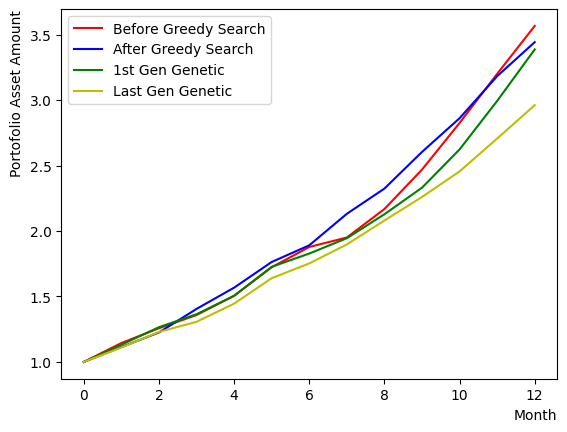

In [7]:
#Genetic Algorithm
Ngenes = 10 # the number of pairs of genes
NGenerations = 5 # the number of generations
# initialize randomly
Genes = list()
for i in range(Ngenes):
    gene = GenerateRandomSolution(Nassets)
    geneSR = EvaluateSolution(gene, Chart)
    Genes.append([geneSR, gene])
Genes = sorted(Genes,reverse=True)

# get the best portfolio in first generation
print("Best Gene 1st generation:")
print(Genes[0][1], EvaluateSolution(Genes[0][1], Chart))
print("")

selected_charts3 = list()
for i in range(Nassets):
    if Genes[0][1][i] == 1:
        selected_charts3.append(Chart[i])
portfolioChart3 = np.mean(selected_charts3, axis=0)


# execute genetic algorithm
K_best = 5 # the number of top genes which are extracted
Ndescendants = 2 # the number of offspring
MaxMutation = 2 # the maximum number of mutations
for iIter in range(NGenerations):
    selected_Genes = Genes[:K_best]
    for gene in selected_Genes:
        Descendants = CreateDescendant(gene[1], Ndescendants, MaxMutation)
        for Descendant in Descendants:
            DescendantSR = EvaluateSolution(Descendant, Chart)
            selected_Genes.append([DescendantSR, Descendant])
    selected_Genes = sorted(selected_Genes, key=lambda x: x[0], reverse=True)
    selected_Genes = copy.deepcopy(selected_Genes[:K_best])

# get the best portfolio in the final generation
print("Best Gene last generation:")
print(selected_Genes[0][1], EvaluateSolution(selected_Genes[0][1], Chart))
print("")
selected_charts4 = list()
for i in range(Nassets):
    if selected_Genes[0][1][i] == 1:
        selected_charts4.append(Chart[i])
portfolioChart4 = np.mean(selected_charts4, axis=0)

# make a comparison plot
plt.plot(list(range(13)), portfolioChart,color="r",label="Before Greedy Search")
plt.plot(list(range(13)), portfolioChart2,color="b",label="After Greedy Search")
plt.plot(list(range(13)), portfolioChart3,color="g",label="1st Gen Genetic")
plt.plot(list(range(13)), portfolioChart4,color="y",label="Last Gen Genetic")
plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.legend()
plt.show()

## Implementation of quantum annealing method using OpenJij

### Method for quantum annealing

To solve the optimization problem in reverse quantum annealing, we will translate the classical algorithm's spin-form results into the formulation used in quantum annealing.

In [8]:
def ConvertSolutionToQuboState(solution):
    output = list()
    for i in range(len(solution)):
        if solution[i] == 1:
            output.append(1)
        else: output.append(0)
    return output

QA_init_state = ConvertSolutionToQuboState(Solution) # use the result from greedy search as an initial state
#QA_init_state = ConvertSolutionToQuboState(selected_Genes[0][1]) # use the best portfolio in the final generation of genetic algorithm as an initial state
#QA_init_state = GenerateRandomSolution(Nassets) # use random initial state
print(QA_init_state)

[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]


#### For forward annealing

Initially, we will execute Forward Annealing.
We construct a QUBO matrix incorporating the stocks' attractiveness and the pairwise correlations of penalties and rewards.
In this following, we perform our computations through Simulated Quantum Annealing (SQA), which emulates quantum annealing on a classical computer.
The enhancement in the final rate of return varies based on the case, yet we can observe that the charts demonstrate greater stability than the results procured by the greedy method.

<class 'numpy.ndarray'>


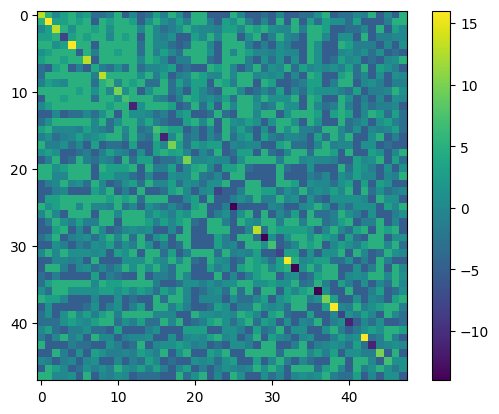

[([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1

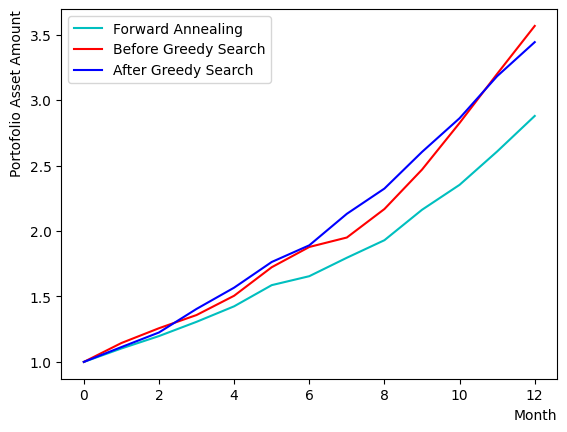

In [9]:
from openjij import SQASampler
sampler = SQASampler()

QUBO = np.random.rand(Nassets**2).reshape(Nassets, Nassets)
for i in range(Nassets):
    for j in range(Nassets):
        QUBO[i][j] = PairwiseCorrMat[i][j]
for i in range(Nassets):
    QUBO[i][i] = QUBO[i][i] + SR_list[i]

print(type(QUBO))
import matplotlib.pyplot as plt
plt.imshow(QUBO)
plt.colorbar()
plt.show()

sampleset_FQA = sampler.sample_qubo(QUBO,num_reads=10)
print(sampleset_FQA.record)
print(sampleset_FQA.record[0][0], EvaluateSolution(sampleset_FQA.record[0][0], Chart))
selected_charts = list()
for i in range(Nassets):
    if sampleset_FQA.record[0][0][i]:
        selected_charts.append(Chart[i])
portfolioChart_FQA = np.mean(selected_charts, axis=0)
plt.plot(list(range(13)), portfolioChart_FQA, color="c", label="Forward Annealing")
plt.plot(list(range(13)), portfolioChart,color="r",label="Before Greedy Search")
plt.plot(list(range(13)), portfolioChart2,color="b",label="After Greedy Search")
plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.legend()
plt.show()

#### For reverse quantum annealing

In reverse annealing, we input the state generated from the classical algorithm as the initial state before annealing. 
The first step is to set up the annealing schedule. 
In this tutorial, using OpenJij, the SQA Hamiltonian is defined as follows:

$$
\mathcal{H}_{\mathrm{SQA}}(s) = s\mathcal{H}_{p}-(1-s)\sum_{i}\sigma_{i}^{x}, 0\leq x\leq 1
$$

where $\mathcal{H}_{p}$ is the problem Hamiltonian that we seek to obtain the optimal solution for, and $s$ and $1-s$ correspond to $B[t]$ and $A[t]$ in reference paper [2] respectively.
The value of $s$ can be set by adding supplementary arguments to `sample_qubo`.

```python
sample_qubo(QUBO, num_reads=10)
```

We can modify the previous section's `sample_qubo` to input the initial state settings and updates as follows: 

```python
sample_qubo(QUBO, schedule = user_schedule, initial_state = user_initial_state, num_reads=10, reinitialize_state = False)
```

where the schedule refers to the annealing schedule.
It has the following structure: ```[0]``` component represents the value of $s$, reflecting the transverse magnetic field's intensity during annealing; 
```[1]``` component is the inverse temperature $\beta$, with a larger value denoting a lower temperature, facilitating the attainment of the ground state (default value of $\beta = 5$); 
and ```[2]``` component denotes the number of quantum Monte Carlo simulation steps, enabling us to alter the length of each schedule.   

The initial state should be assigned to the `initial_state` argument. 
If the `reinitialize_state` option is set to `False`, the previous step's annealing output is designated as the next step's annealing initial state in the iteration.
In the sample script above, commencing from the classical algorithm's prepared initial state, RQA would execute ten times. 
The default of the optional argument, `True`, reset the initial state every time it runs; 
if we want to execute RQA once and contrast the results multiple times, we set `reinitialize_state = True`.  

Now, let's fabricate a schedule for reverse annealing.
Since OpenJij sampler performs quantum Monte Carlo with a given $s$ and $\beta$ over a specified number of MC steps, we need to create a schedule in which $s$ and $\beta$ gradually change by linking short constants to facilitate RQA's functionality.
Here, we focus on the change in $s$ and plot it to observe an inverted trapezoidal schedule.
The horizontal axis represents the quantum Monte Carlo method's number of Monte Carlo steps.
By rewriting the schedule creation function's contents, we can generate any schedule shapes.

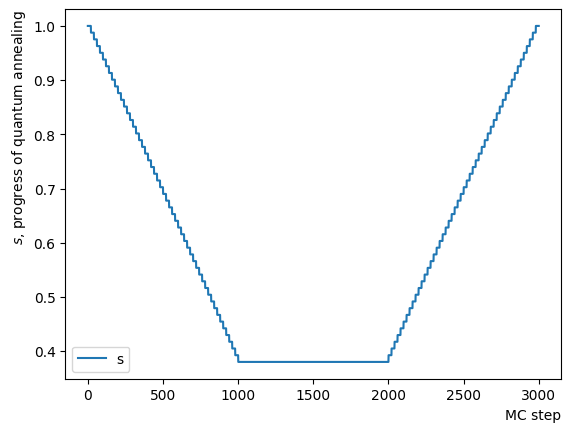

In [10]:
def ScheduleFunction(x, RQAschedule):
    for step in RQAschedule:
        length = step[2]
        if x - length > 0:
            x = x-length
            continue
        else:
            s = step[0]
            return s


def ConvertScheduleToPlot(RQAschedule):
    TotalLength = np.sum(RQAschedule, axis=0)[2]
    x = np.arange(0, TotalLength+1)
    s = [ScheduleFunction(n, RQAschedule) for n in x]
    plt.plot(x, s ,label="s")
    plt.xlabel("MC step", loc="right")
    plt.ylabel("$s$, progress of quantum annealing", loc="top")
    plt.legend()
    plt.show()

#Create RQA schedule
RQAschedule = []
NReverseStep = 50
NPauseStep = 50
NForwardStep = 50
NMCStep = 20
TargetS = 0.38
ReverseStep = (1.0 - TargetS) / NReverseStep
ForwardStep = (1.0 - TargetS) / NForwardStep
beta = 5.
#Reverse Step
for i in range(NReverseStep):
    step_sche = [1.0-i*ReverseStep, beta, NMCStep]
    RQAschedule.append(step_sche)   

#Pause Step
RQAschedule.append([TargetS, beta, NPauseStep*NMCStep])

#Forward Step
for i in range(NForwardStep):
    step_sche = [TargetS+(i+1)*ForwardStep, beta, NMCStep]
    RQAschedule.append(step_sche)

#Plot Annealing Schedule
ConvertScheduleToPlot(RQAschedule)

Let's execute the RQA utilizing the `sample_qubo` function in conjunction with the schedule and initial conditions set up thus far.
Simultaneously, we compare the outcomes of the greedy method, forward annealing, and RQA.
The results indicate that the setup in this tutorial frequently yields the same optimal solution as forward annealing, owing to the constraints imposed by the size of the set of assets.

[([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1

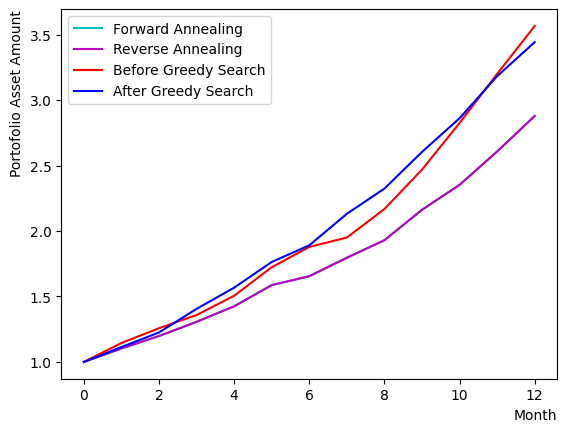

Forward Quantum Annealing Result:
[1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 1 1 0 1 1 1] 3.7873836272238077
Reverse Quantum Annealing Result:
[1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 1 1 0 1 1 1] 3.7873836272238077


In [11]:
# prepare initial state 
init_state = QA_init_state

#Reverse Annealing
sampleset_RQA = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=False)
print(sampleset_RQA.record)

# compare charts
selected_charts = list()
for i in range(Nassets):
    if sampleset_RQA.record[0][0][i]:
        selected_charts.append(Chart[i])
portfolioChart_RQA = np.mean(selected_charts, axis=0)
plt.plot(list(range(13)), portfolioChart_FQA, color="c", label="Forward Annealing")
plt.plot(list(range(13)), portfolioChart_RQA, color="m", label="Reverse Annealing")
plt.plot(list(range(13)), portfolioChart,color="r",label="Before Greedy Search")
plt.plot(list(range(13)), portfolioChart2,color="b",label="After Greedy Search")
plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.legend()
plt.show()
# compare the results
print("Forward Quantum Annealing Result:")
print(sampleset_FQA.record[0][0], EvaluateSolution(sampleset_FQA.record[0][0], Chart))
print("Reverse Quantum Annealing Result:")
print(sampleset_RQA.record[0][0], EvaluateSolution(sampleset_RQA.record[0][0], Chart))

### Checking reverse quantum annealing

Since the final output alone fails to provide insight into the behavior of RQA, we dissect the phase and observe its behavior.
Initially, we investigate the reverse phase.
Similarly, an annealing schedule is set up and annealing is carried out using the designated schedule and initial state.
Here, for clarity, we have altered the $s$ value and inverse temperature at which the reverse phase terminates.
Additionally, annealing is arranged to commence from the same initial state on each occasion, as opposed to undergoing iteration.
The results show that the reverse phase process ascends from the previously attained solution to a higher energy state.
Furthermore, as the solution stays in a different state during each execution, we can deduce that the solution differs at a higher energy level.

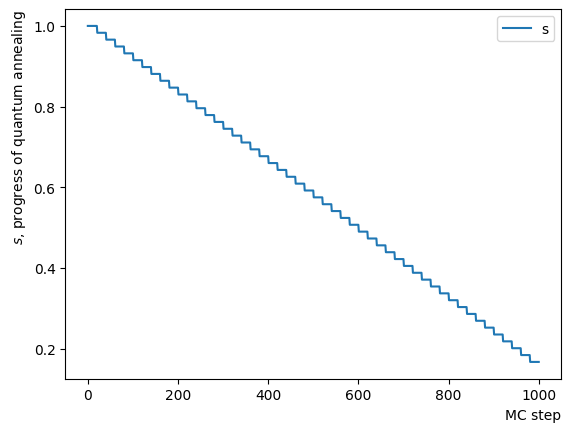

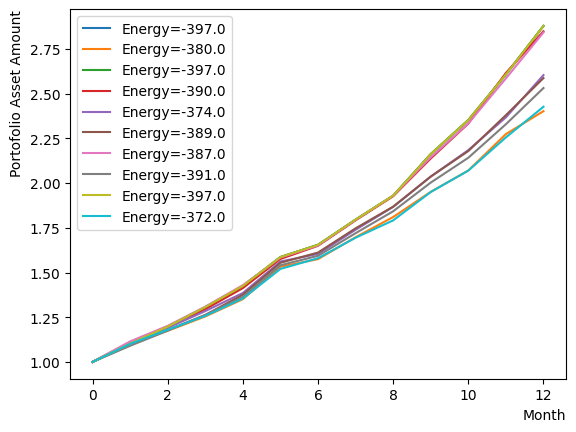

[([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1], -380., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -390., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1], -374., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1], -389., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1

In [12]:
#Create RQA schedule
RQAschedule = []
NReverseStep = 50
TargetS = 0.15 # return to more random state よりランダムな状態に戻す
ReverseStep = (1.0 - TargetS) / NReverseStep
beta = 5.0
MC_step = 20
#Reverse Step
for i in range(NReverseStep):
    step_sche = [1.0-i*ReverseStep, beta, MC_step]
    RQAschedule.append(step_sche)   

ConvertScheduleToPlot(RQAschedule)
init_state = QA_init_state 
    

sampleset_RQA_Reverse = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) #毎回同じ初期状態からアニーリング
for state in sampleset_RQA_Reverse.record:
    selected_charts = list()
    for i in range(Nassets):
        if state[0][i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))

plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.legend()
plt.show()
print(sampleset_RQA_Reverse.record)

Next, we add a pause phase.
After the addition of the pause phase, annealing is performed similarly, and the results are evaluated.
As the addition of this phase is tantamount to extending the number of MC steps of the final stage of the reverse phase described above in terms of implementation, the results are as dispersed as those obtained in the reverse phase-only scenario depicted previously.

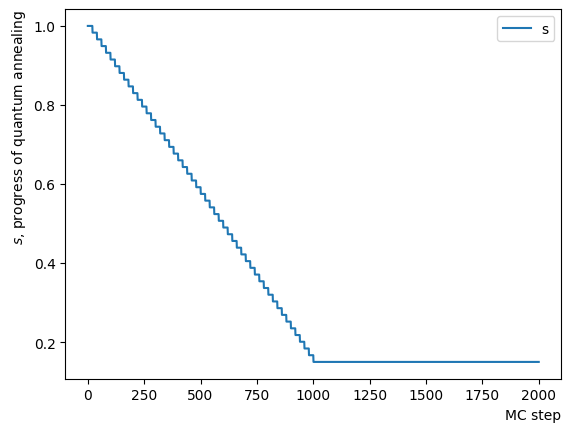

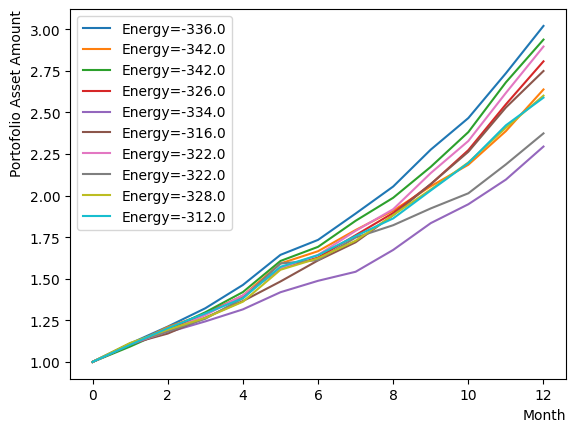

[([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1], -336., 1)
 ([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1], -342., 1)
 ([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -342., 1)
 ([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1], -326., 1)
 ([0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1], -334., 1)
 ([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1], -316., 1)
 ([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1

In [13]:
#Create Pause Step
NPauseStep = 50
TargetS = 0.15 # return to more random state 
beta = 1.0 # allow for easier thermal hopping at higher temperatures
MC_step = 20
step_sche = [TargetS, beta, MC_step*NPauseStep]
RQAschedule.append(step_sche)

#print(RQAschedule)
ConvertScheduleToPlot(RQAschedule)
init_state = QA_init_state 

sampleset_RQA_Reverse_Pause = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) # execute annealing from the same initial state every time 
for state in sampleset_RQA_Reverse_Pause.record:
    selected_charts = list()
    for i in range(Nassets):
        if state[0][i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))

plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.legend()
plt.show()
print(sampleset_RQA_Reverse_Pause.record)

Finally, we incorporate a forward phase and execute annealing.
This configuration is set up under conditions of slightly relaxed temperature and magnetic field relative to the previous sample.
As a result, we can observe that the known optimal solution through quantum annealing is obtained for this particular set of stocks.
Similar to the first example in the RQA section, we can observe that the optimal solution is obtained by RQA.  

Since the conditions are slightly lenient, the solutions do not converge, and we can see the presence of multiple sub-optimal solutions with comparable energies.
Among these solutions, we can also detect the presence of a portfolio whose final return outperforms the optimal solution obtained through forward annealing in certain cases and whose profile is relatively smooth.
A closer examination of that portfolio details reveals that the substantial returns were achieved through a combination of specific stocks exhibiting substantial appreciation rates and stocks with relatively low volatility that possess inverse correlations.
Although such a portfolio may be desirable in actual investment scenarios, the "Shape ratio is maximized" condition set up in this tutorial resulted in a relatively modest portfolio Sharpe ratio, which was deemed suboptimal through quantum annealing.

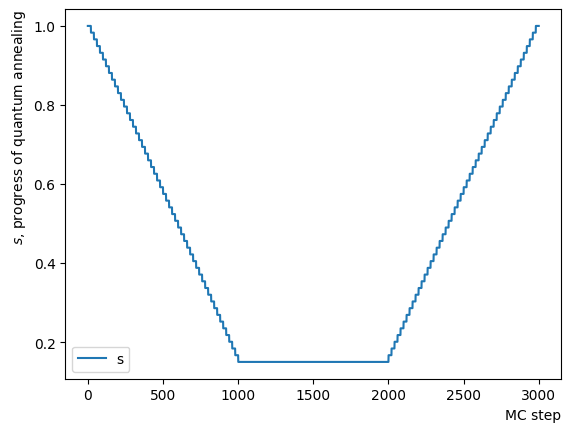

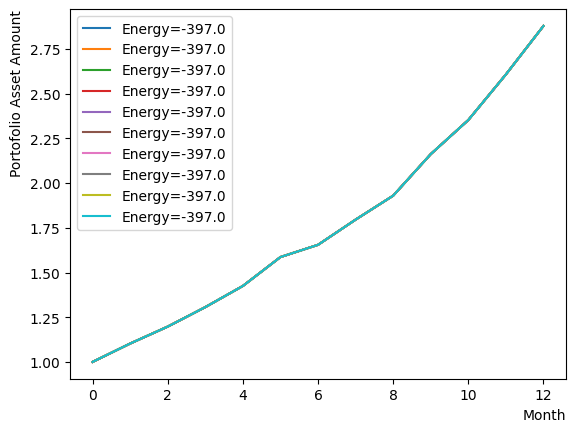

[([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], -397., 1)
 ([1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1

In [14]:
#Create Forward Step
NForwardStep = 50
TargetS = 0.15 # return to more random state 
ForwardStep = (1.0 - TargetS) / NForwardStep
beta = 5.0 # allow for easier thermal hopping at higher temperatures
MC_step = 20

#Forward Step
for i in range(NForwardStep):
    step_sche = [TargetS+(i+1)*ForwardStep, beta, MC_step]
    RQAschedule.append(step_sche)

ConvertScheduleToPlot(RQAschedule)
init_state = QA_init_state 

sampleset_RQA_Reverse_Pause_Forward = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) # execute annealing from the same initial state every time 
for state in sampleset_RQA_Reverse_Pause_Forward.record:
    selected_charts = list()
    for i in range(Nassets):
        if state[0][i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))

plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.legend()
plt.show()
print(sampleset_RQA_Reverse_Pause_Forward.record)

### Parameter search for specifying RQA schedule

Examining the effects of the parameters in separate phases reveals that results vary based on the values of $s$ and $\beta$, as well as the number of steps in the Quantum Monte Carlo method. 
From this perception, to achieve optimal performance with reverse annealing, it is necessary to determine appropriate values for these parameters. 

#### In reverse phase

Initially, we consider their impact on the reverse phase.
We start by analyzing the effect of $s$, which represents the degree of quantum annealing.
The transverse magnetic field intensity represented by $s$ must be set to an optimal value to allow for dispersion beyond the potential barrier around the local solution reached through initial annealing. 
Results show that for $s \leq 0.20$, thermal fluctuations become dominant and variations increase, so a finer scan around $s \sim 0.2$ is expected to yield the optimal value. 

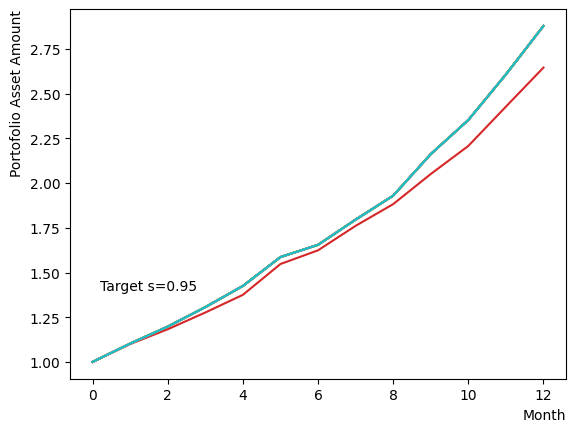

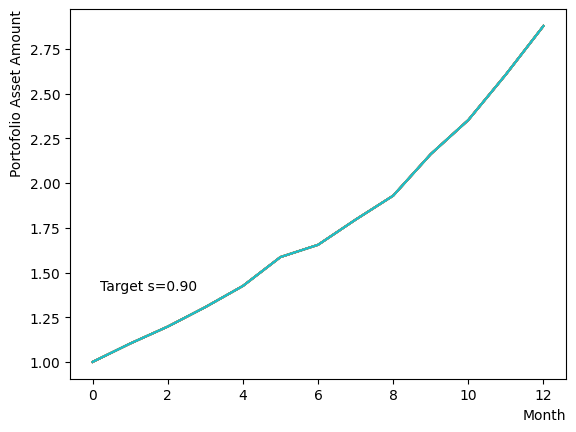

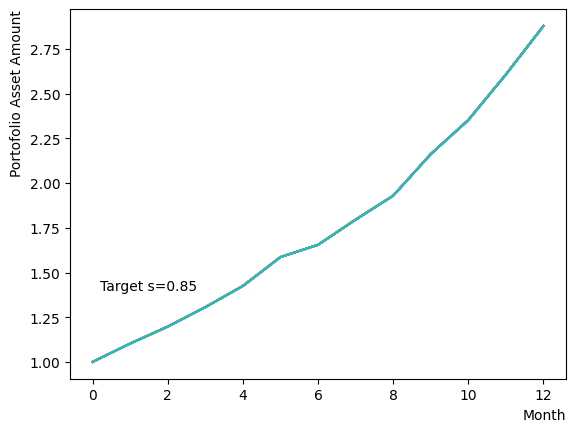

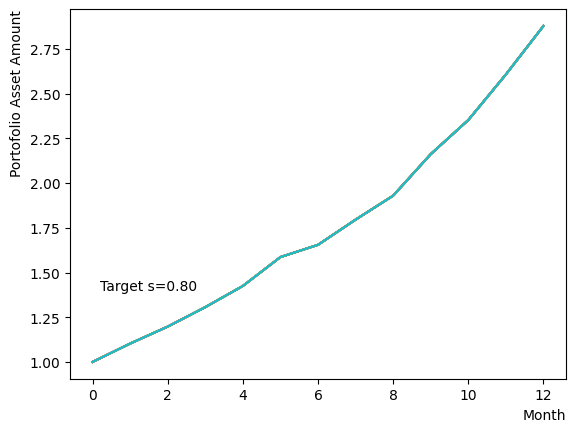

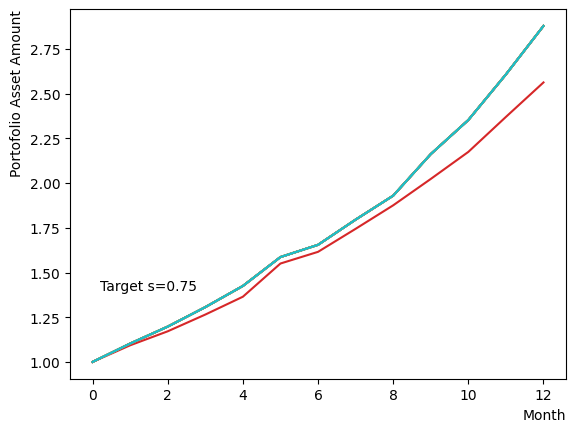

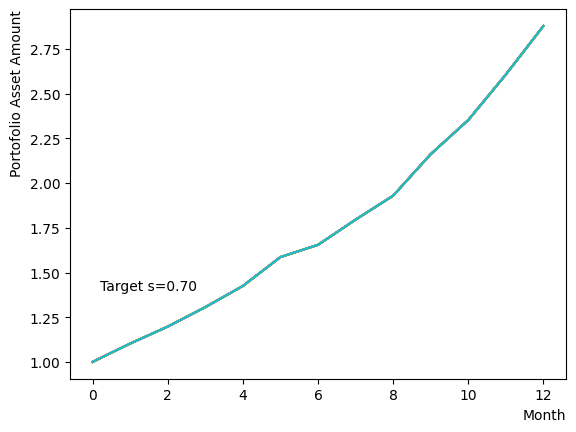

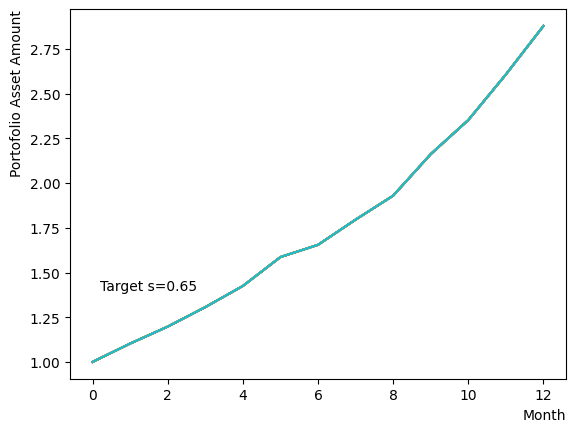

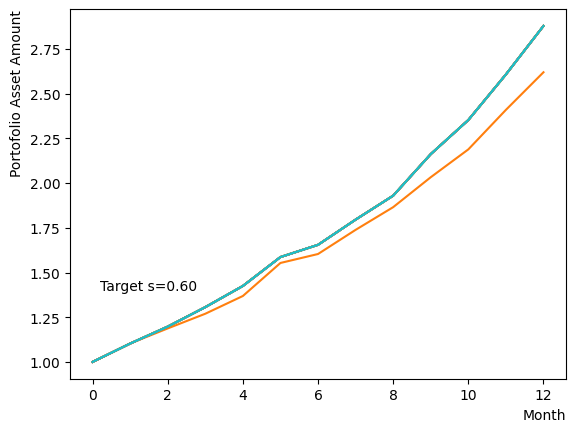

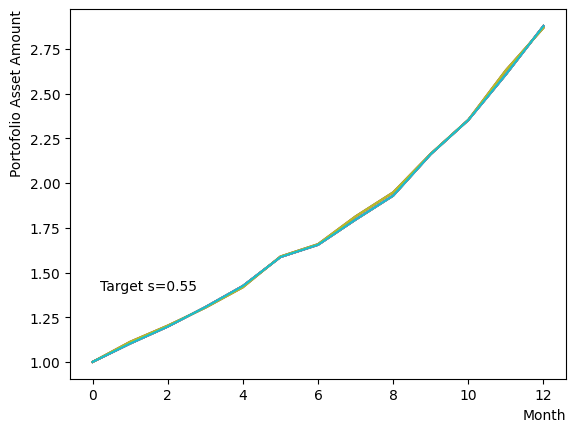

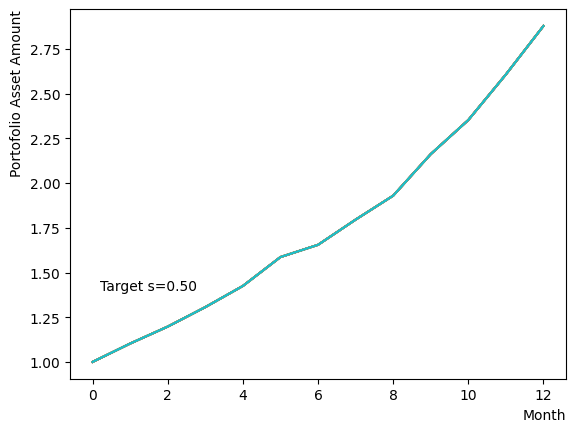

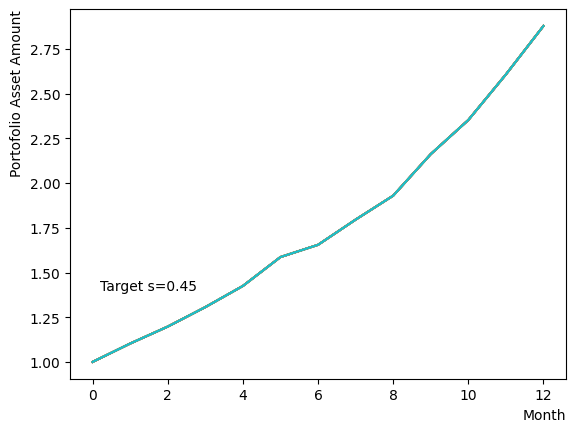

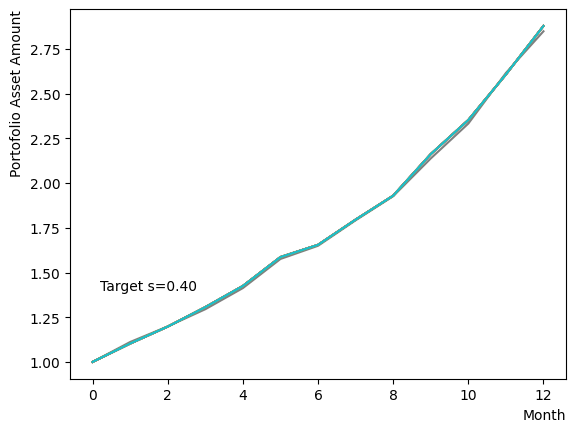

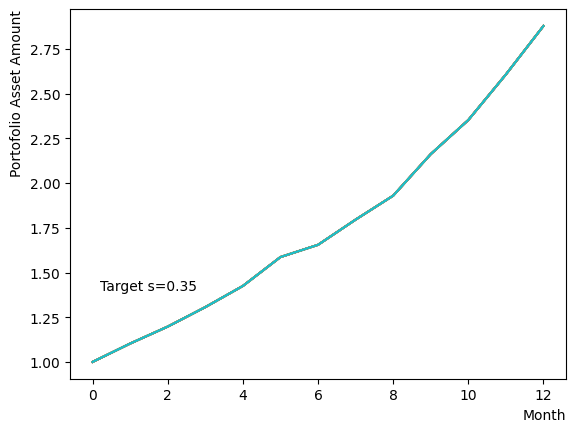

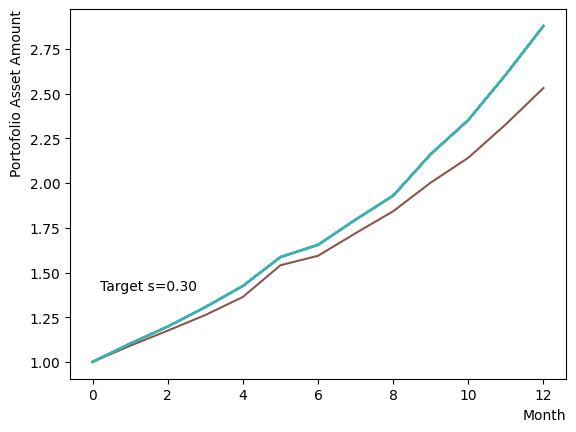

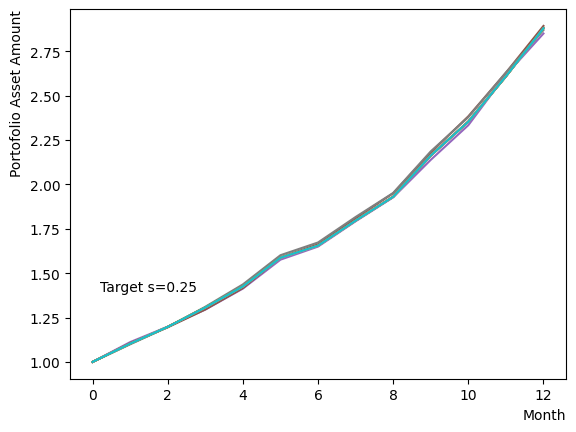

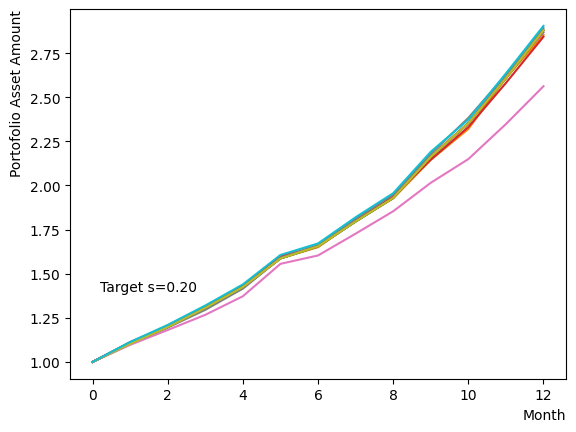

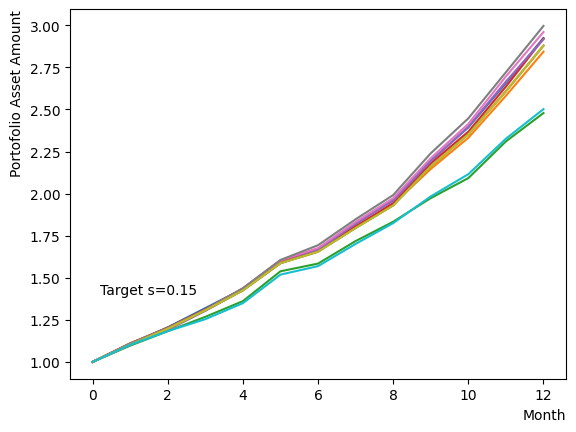

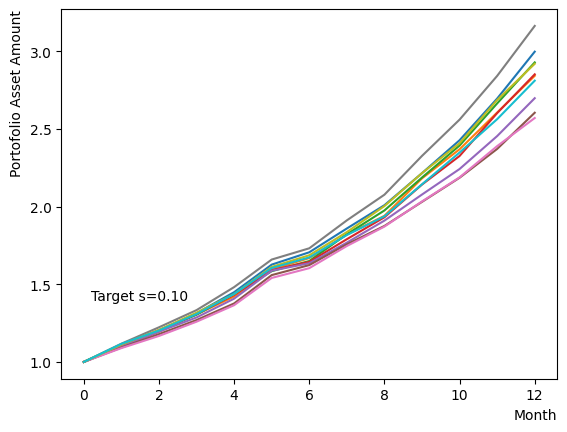

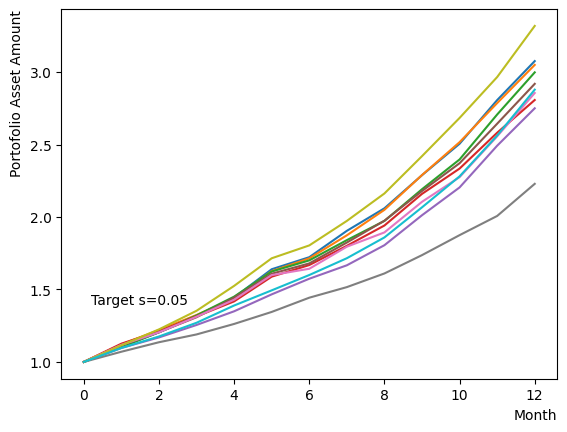

In [15]:
for TargetS in reversed(np.arange(0.05, 1.0, 0.05)):
    #Create RQA schedule
    RQAschedule = []
    NReverseStep = 50
    ReverseStep = (1.0 - TargetS) / NReverseStep
    beta = 5.0
    MC_step = 20
    #Reverse Step
    #for i in range(NReverseStep):
    for i in range(NReverseStep):
        step_sche = [1.0-i*ReverseStep, beta, MC_step]
        RQAschedule.append(step_sche)   

    init_state = QA_init_state 


    sampleset_RQA_Reverse = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) # execute annealing from the same initial state every time 
    for state in sampleset_RQA_Reverse.record:
        selected_charts = list()
        for i in range(Nassets):
            if state[0][i]:
                selected_charts.append(Chart[i])
        portfolioChart = np.mean(selected_charts, axis=0)
        plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))
    
    plt.xlabel("Month", loc="right")
    plt.ylabel("Portofolio Asset Amount", loc="top")
    plt.text(0.2,1.4, "Target s="+'{:.2f}'.format(TargetS))
    plt.show()

Next, we consider the effect of $\beta$.
$\beta = \frac{1}{k_\mathrm{B} T}$ represents the inverse temperature, where a larger $\beta$ means that the system is cooler.
In other words, the larger $\beta$ is, the more easily the overall state reaches to the ground state and behaves more likely an "annealed" state.
For a constant transverse magnetic field, as $\beta$ increases, the effectiveness of the transverse magnetic field decreases and begins to resemble that of a large $s$.
For more details on this effect in OpenJij, please refer to this [Qiita article](https://qiita.com/ground0state/items/0f61c3efc7f12fd96d05).  

It is acknowledged that the effect change by the typical scale of energy present within the QUBO matrix.
In this tutorial, the typical value of the QUBO matrix roughly equates to $5$, thus we expect the variation to occur around $\beta=5.0$.

Text(0, 1, 'Number of entries')

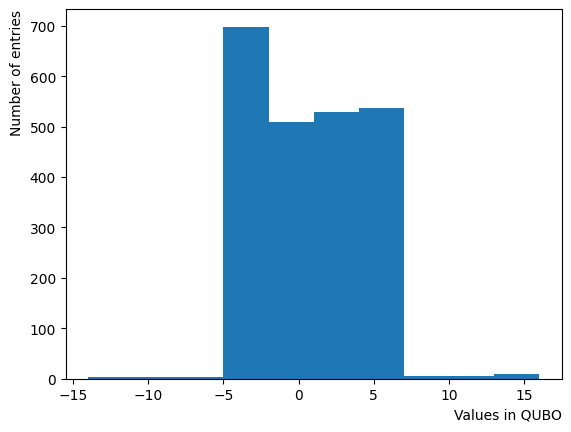

In [16]:
plt.hist((QUBO).flatten())
plt.xlabel("Values in QUBO", loc="right")
plt.ylabel("Number of entries", loc="top")

We generate a logarithmic array of $\beta$ and implement a Reverse Phase with all parameters fixed, excluding $s$.
As expected, the dispersion of the final state becomes minimal around $\beta=5$, and for higher values of $\beta$, we observe that the states converge to a few states.

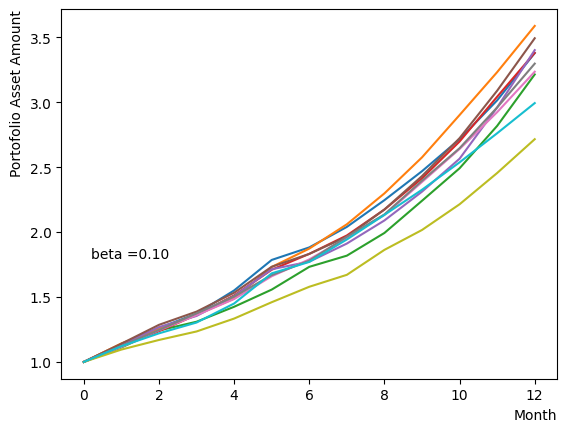

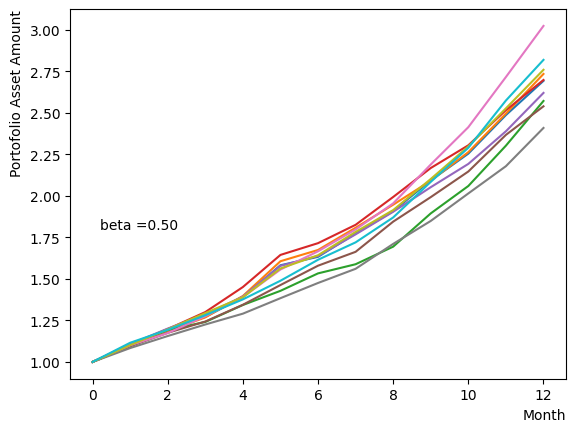

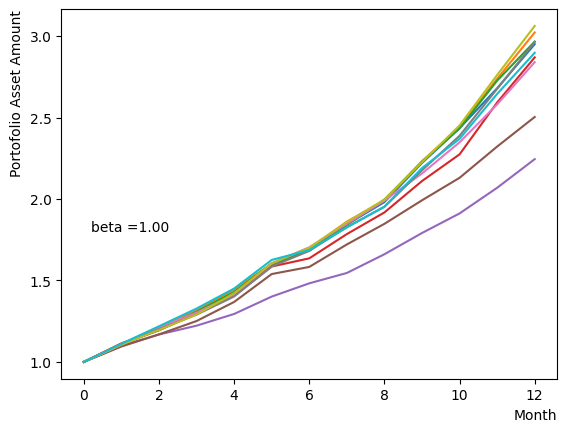

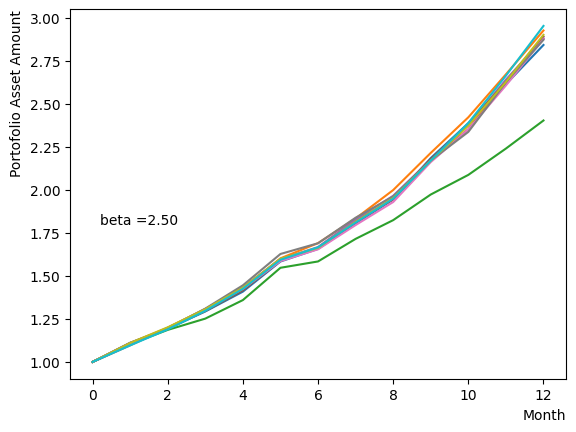

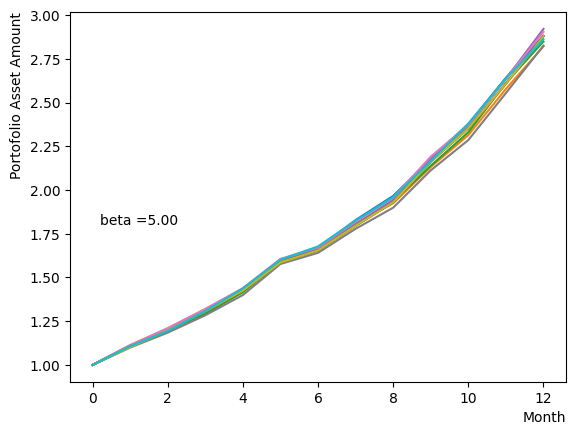

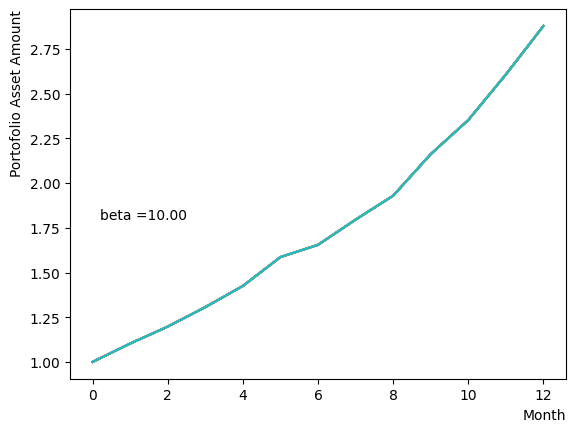

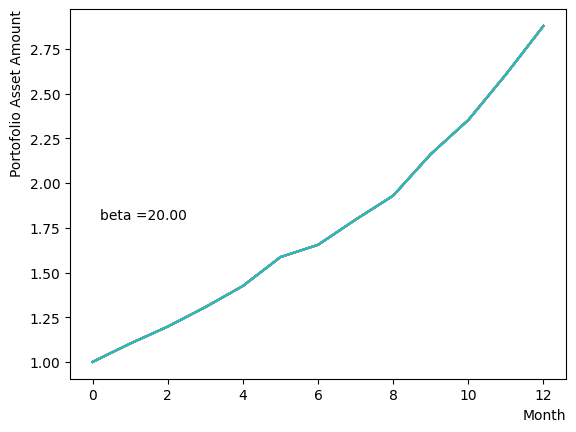

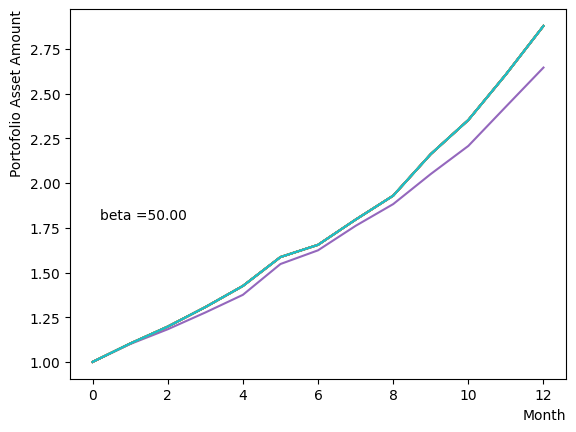

In [17]:
for beta in [0.1,0.5,1.0,2.5,5.0,10.0,20.0,50.0]:
    #Create RQA schedule
    RQAschedule = []
    NReverseStep = 50
    TargetS = 0.18
    ReverseStep = (1.0 - TargetS) / NReverseStep
    MC_step = 20
    #Reverse Step
    #for i in range(NReverseStep):
    for i in range(NReverseStep):
        step_sche = [1.0-i*ReverseStep, beta, MC_step]
        RQAschedule.append(step_sche)   

    init_state = QA_init_state 


    sampleset_RQA_Reverse = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) # execute annealing from the same initial state every time 
    for state in sampleset_RQA_Reverse.record:
        selected_charts = list()
        for i in range(Nassets):
            if state[0][i]:
                selected_charts.append(Chart[i])
        portfolioChart = np.mean(selected_charts, axis=0)
        plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))
    
    plt.xlabel("Month", loc="right")
    plt.ylabel("Portofolio Asset Amount", loc="top")
    plt.text(0.2,1.8, "beta ="+'{:.2f}'.format(beta))
    plt.show()

Next, we analyze the impact of schedule partitioning.
Here we examine extreme cases, such as the step function, as well as the scenario of a gradual alteration achieved by dividing the schedule into smaller segments.
As the results indicate, the state does not significantly change when the number of divisions is limited, whereas an increase in the number of divisions leads to noticeable variation.
Additionally, a substantial increase in the number of divisions only increases the computational time and trivial differences in the outcomes.
For the portfolio optimization problem addressed in this tutorial, approximately $50$ is found to not pose a problem.

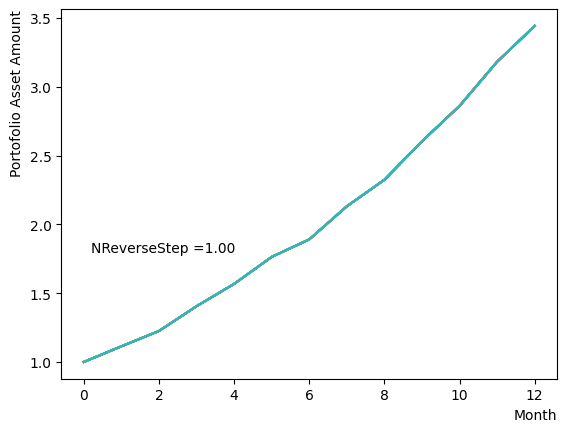

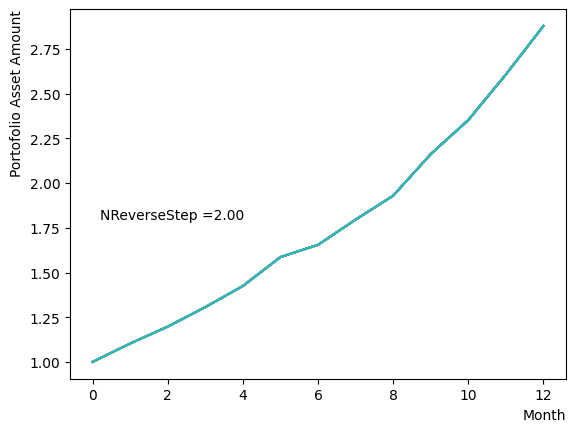

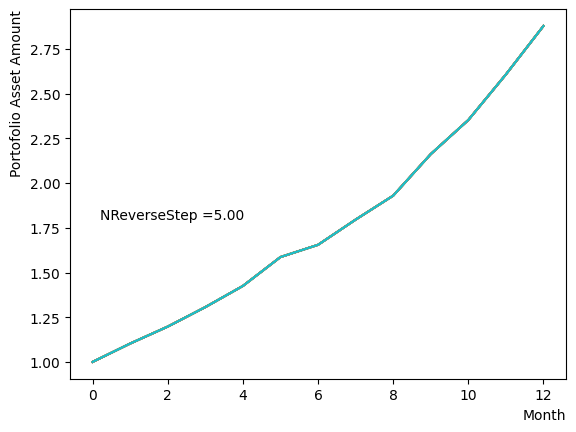

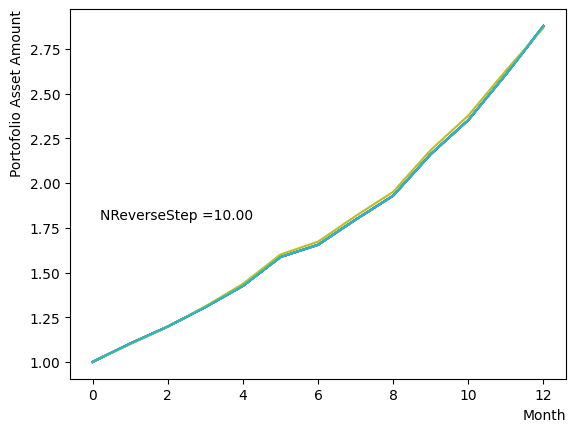

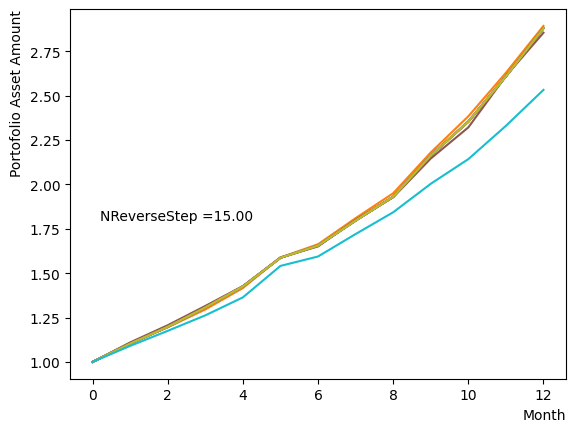

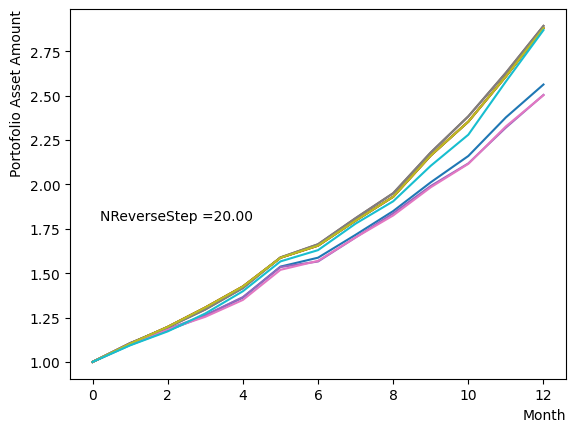

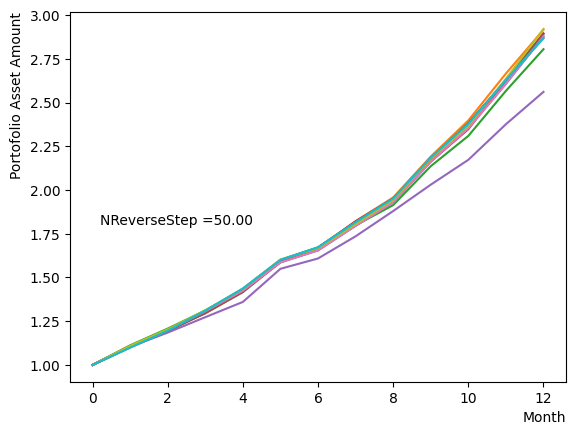

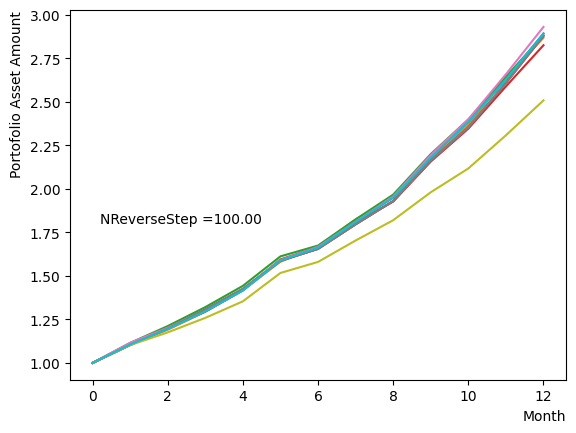

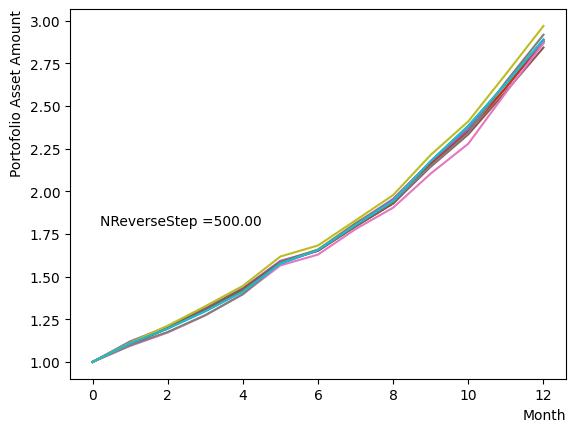

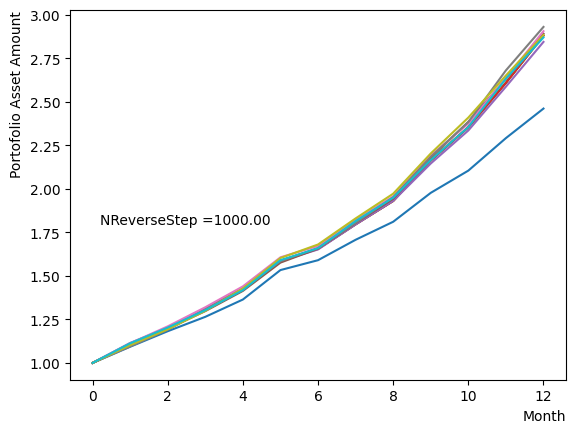

In [18]:
for NReverseStep in [1,2,5,10,15,20,50,100,500,1000]:
    #Create RQA schedule
    RQAschedule = []
    TargetS = 0.18
    ReverseStep = (1.0 - TargetS) / NReverseStep
    beta = 5.0
    MC_step = 20
    #Reverse Step
    #for i in range(NReverseStep):
    for i in range(NReverseStep):
        step_sche = [1.0-i*ReverseStep, beta, MC_step]
        RQAschedule.append(step_sche)   

    init_state = QA_init_state 


    sampleset_RQA_Reverse = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) # execute annealing from the same initial state every time 
    for state in sampleset_RQA_Reverse.record:
        selected_charts = list()
        for i in range(Nassets):
            if state[0][i]:
                selected_charts.append(Chart[i])
        portfolioChart = np.mean(selected_charts, axis=0)
        plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))
    plt.xlabel("Month", loc="right")
    plt.ylabel("Portofolio Asset Amount", loc="top")
    plt.text(0.2,1.8, "NReverseStep ="+'{:.2f}'.format(NReverseStep))
    plt.show()

Also, with regards to MC steps, it is determined that its impact on the final result is negligible unless the product of (number of divisions)x(MC steps) is excessively small.
In the case of the default setting with `SQASampler()`, about $1000$ should work.

#### For pause phase

As already explained, the pause phase is an extension of the final step of the reverse phase, behaves similarly to the reverse phase when altering $s$ and $\beta$ of the overall annealing.
Also, since the steps of the pause phase is equivalent to the extension of the final step, its impact on the reverse phase is expected to be limited, even if it is changed.  

However, modifying only $\beta$ during the pause phase resembles classical annealing with incomplete quantum annealing.
Here we examine the effect of changing the system temperature from $\beta=5.0$ to a gradual target $\beta$.
We obtain the results that are similar to the final state when annealing is performed at a different $\beta$ in reverse phase.

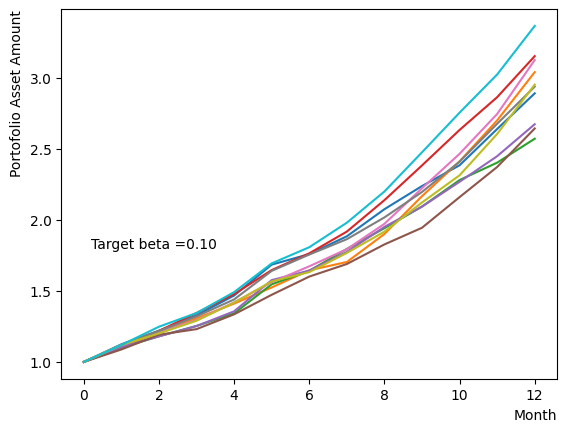

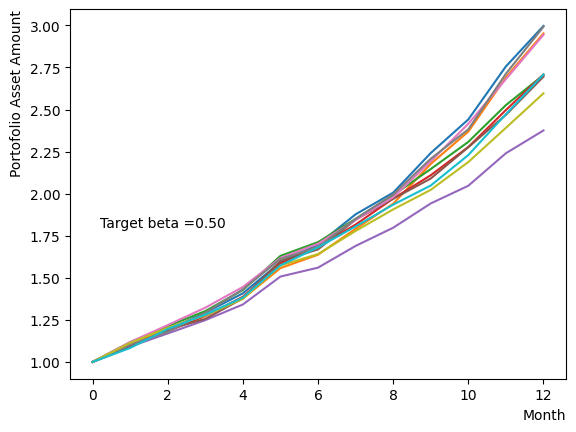

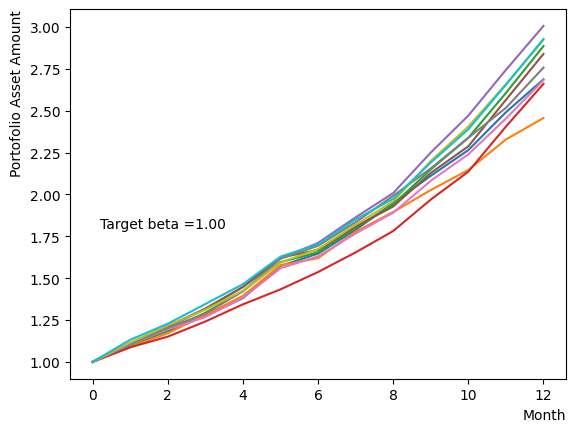

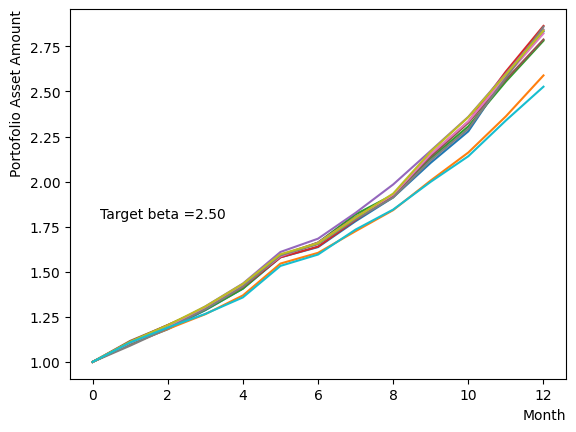

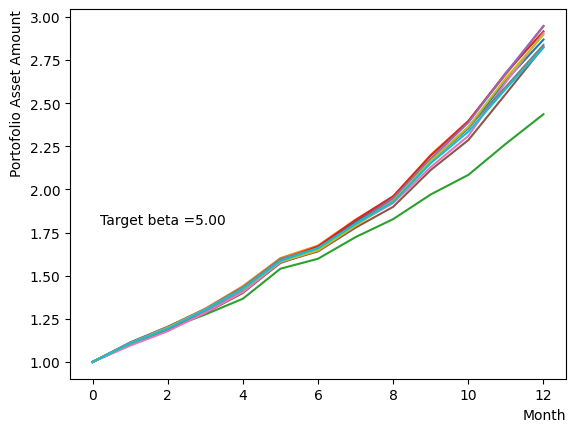

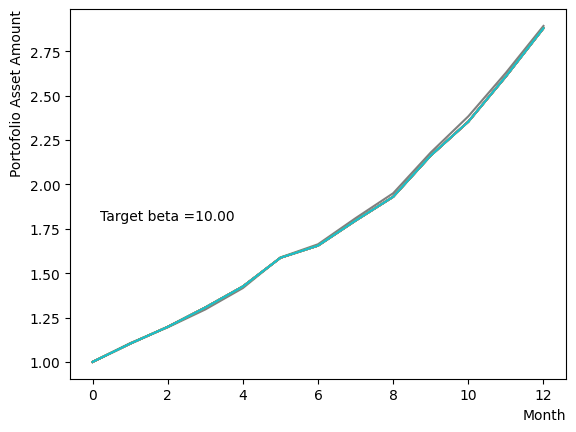

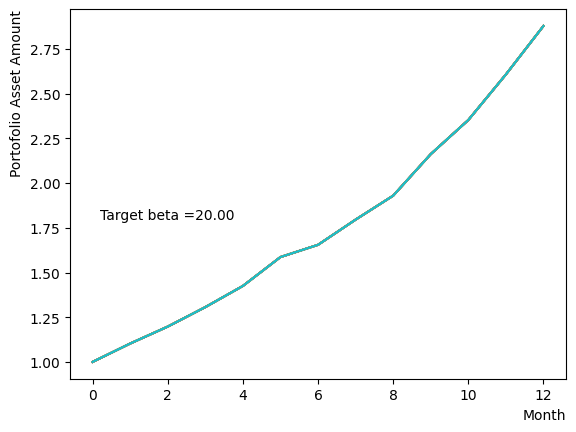

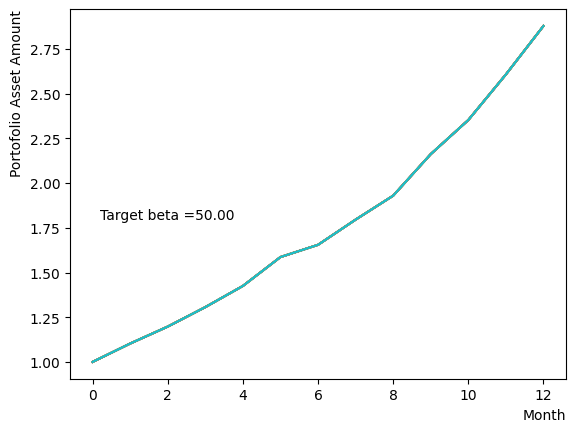

In [19]:
for beta in [0.1,0.5,1.0,2.5,5.0,10.0,20.0,50.0]:
    #Create RQA schedule
    RQAschedule = []
    NReverseStep = 50
    TargetS = 0.18
    ReverseStep = (1.0 - TargetS) / NReverseStep
    MC_step = 20
    #Reverse Step
    #for i in range(NReverseStep):
    for i in range(NReverseStep):
        step_sche = [1.0-i*ReverseStep, 5.0, MC_step]
        RQAschedule.append(step_sche) 
    
    #Pause Phase
    NPauseStep = 50
    betaStep = (5.0-beta) / NPauseStep
    for i in range(NReverseStep):
        step_sche = [TargetS, 5.0-i*betaStep, MC_step]
        RQAschedule.append(step_sche) 

    init_state = QA_init_state 


    sampleset_RQA_Reverse_Pause = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) # execute annealing from the same initial state every time 
    for state in sampleset_RQA_Reverse_Pause.record:
        selected_charts = list()
        for i in range(Nassets):
            if state[0][i]:
                selected_charts.append(Chart[i])
        portfolioChart = np.mean(selected_charts, axis=0)
        plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))
    
    plt.xlabel("Month", loc="right")
    plt.ylabel("Portofolio Asset Amount", loc="top")
    plt.text(0.2,1.8, "Target beta ="+'{:.2f}'.format(beta))
    plt.show()

#### For forward phase

The forward phase is the stage in which standard quantum annealing is executed, starting from the states acquired through the reverse and pause Phases.
The conditions for the parameters in this phase we have to consider are essentially equivalent to those required for standard annealing to work correctly.
We examine $\beta$ and the number of division steps in the same way as reverse and pause phases , we find that even with a modest number of divisions and $\beta$, the results converged to the optimal solution.  

An example script is shown below.
In the reverse phase and pause phase, we employ the settings obtained from previous investigations, with only the forward phase undergoing annealing with a coarse resolution and small $\beta$.

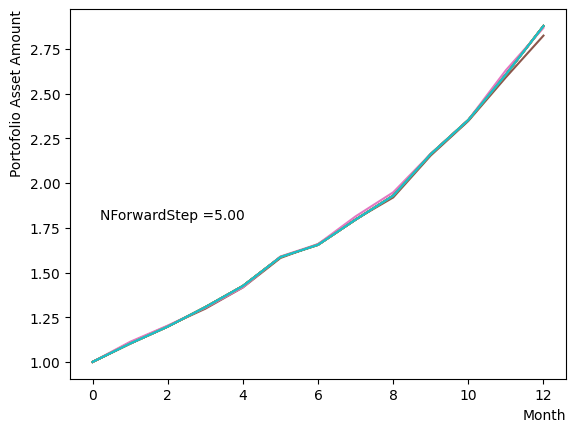

In [20]:
#Create RQA schedule
RQAschedule = []
NReverseStep = 50
TargetS = 0.18
ReverseStep = (1.0 - TargetS) / NReverseStep
MC_step = 20
#Reverse Step
#for i in range(NReverseStep):
for i in range(NReverseStep):
    step_sche = [1.0-i*ReverseStep, 5.0, MC_step]
    RQAschedule.append(step_sche) 
    
#Pause Phase
NPauseStep = 50
step_sche = [TargetS, 5.0, MC_step*NPauseStep]
RQAschedule.append(step_sche) 

#Forward Phase
NForwardStep = 5
ForwardStep = (1.0 - TargetS) / NForwardStep
for i in range(NForwardStep):
    step_sche = [TargetS+(i+1)*ForwardStep, 2.5, MC_step]
    RQAschedule.append(step_sche)

init_state = QA_init_state 

sampleset_RQA_Reverse_Pause_Forward = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=True) # execute annealing from the same initial state every time 
for state in sampleset_RQA_Reverse_Pause_Forward.record:
    selected_charts = list()
    for i in range(Nassets):
        if state[0][i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart, label=("Energy="+str(state[1])))

plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.text(0.2,1.8, "NForwardStep ="+'{:.2f}'.format(NForwardStep))
plt.show()

## Concluding remarks

We implemented reverse quantum annealing utilizing OpenJij to solve a portfolio optimization problem.
In this tutorial, we elucidated the RQA problem formulation, the procedure for specifying the schedule, and the parameters to take into account when performing RQA.
We showed that the RQA method can be used to obtain the correct optimal solution.  

Similar methods can be employed to discover a better solution for other difficult problem with numerous suboptimal solutions close to the optimal one. 
If we only obtain a predicament with local minimum through standard quantum annealing, attempting RQA in this manner may assist in resolving the predicament.  

Additionally, there were some aspects of RQA that we did not discuss in this tutorial, such as the effect of the schedule from a linear function to a nonlinear form, yet we can be easily implemented it by modifying the code in this treatise. 
If you are interested, please give it a try.

## Appendix A: if the simulation results are not good...

The script in this tutorial to generate a stock set is not guaranteed to yield an "admirable" set of stocks. 
Therefore, there exists the possibility of experimenting with sets that possess a biased distribution in certain instances. 
In such situations, the genetic algorithm calculation might experience an extended execution time or RQA might not converge with parameters such as $s$ or $\beta$ that were utilized by default in this tutorial. 
In such cases, we might consider regenerating the stock set or manually adjusting the RQA parameters to reach the optimal resolution.

## Appendix B: Executing RQA on the D-Wave machine

RQA can also be performed on D-Wave machines by using the method described in this tutorial.
We show a sample script below.
The schedule settings and other arguments differ based on the implementation and the discrepancy between the simulation and the actual machine, however, the implementation is fundamentally the same. 
For more details, please refer to the documentation on the official D-Wave website.
Moreover, the difference in outcomes between standard annealing and RQA is more likely to become apparent on an actual device, given that the effects of noise and the like are more likely to be observed.

In [ ]:
from dwave.system import DWaveSampler, EmbeddingComposite

token = '*** your user token ***'
endpoint = '*** your dwave endpoint***' #'https://cloud.dwavesys.com/sapi/' as defaults

dw_sampler = DWaveSampler(solver='Advantage_system4.1', token=token) #Choose your dwave machine/simulator
sampler = EmbeddingComposite(dw_sampler)

Nassets = 48


# RQA schedule
timing = (0,1,2,3) # start and end time of each phase 
Ratio = (1.0,0.38,0.38,1.0) # value of s when each phase changes
schedule = list(zip(timing,Ratio)) # put them together in a schedule 
plt.plot(timing,Ratio)
plt.show()

#Create QUBO
QUBO = np.random.rand(Nassets**2).reshape(Nassets, Nassets)
for i in  range(Nassets):
    for j in range(Nassets):
        QUBO[i][j] = PairwiseCorrMat[i][j]
for i in range(Nassets):
    QUBO[i][i] = QUBO[i][i] + SR_list[i]

import matplotlib.pyplot as plt
plt.imshow(QUBO)
plt.colorbar()
plt.show()

#FQA
sampleset = sampler.sample_qubo(QUBO,num_reads=10)
print(sampleset.record)

min_forword = 0
for result in sampleset.record:
    if result[1] < min_forword:
        min_forword = result[1]
        best_forword = result[0]
selected_charts = list()
for i in range(Nassets):
    if best_forword[i]:
        selected_charts.append(Chart[i])
portfolioChart_FQA = np.mean(selected_charts, axis=0)
plt.plot(list(range(13)), portfolioChart_FQA,color="r",label="Forward Annealing")

#RQA
sampleset_RQA = sampler.sample_qubo(QUBO,num_reads=10,  anneal_schedule=schedule, initial_state = QA_init_state)
print(sampleset_RQA.record)

min_RQA = 0
for result in sampleset_RQA.record:
    if result[1] < min_RQA:
        min_RQA = result[1]
        best_RQA = result[0]
selected_charts = list()
for i in range(Nassets):
    if best_RQA[i]:
        selected_charts.append(Chart[i])
portfolioChart_RQA = np.mean(selected_charts, axis=0)
plt.plot(list(range(13)), portfolioChart_RQA,color="b",label="Reverse Annealing")
plt.xlabel("Month", loc="right")
plt.ylabel("Portofolio Asset Amount", loc="top")
plt.legend()
plt.show()


## References

1. Harry Markowitz, "Portfolio selection", The journal of finance, 7(1):77–91 (1952)
2. [Davide Venturelli, Alexei Kondratyev, "Reverse Quantum Annealing Approach to Portfolio Optimization Problems", Quantum Machine Intelligence volume 1, pages17–30 (2019)](https://link.springer.com/article/10.1007/s42484-019-00001-w)
3. Sharpe, William F., “Mutual fund performance”, The Journal of Business 39 (1), 119-138 (1966)